# Forecasting with XGBoost Regressor Model

In [18]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from feature_engine.creation import CyclicalFeatures
from feature_engine.transformation import LogCpTransformer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (LagFeatures, WindowFeatures)
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import (mean_squared_error, 
                             r2_score, 
                             mean_absolute_error, 
                             mean_absolute_percentage_error
                            )
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from optuna.samplers import TPESampler
import xgboost as xgb

In [2]:
price_df = pd.read_csv("../data/processed/price_actual_df.csv", parse_dates=["time"])
price_df = price_df.set_index("time") \
                   .asfreq("H") \
                   .sort_index()

## 1. Outliers detection and removal

In [4]:
def remove_outliers(df, value_col, period = None, robust = True):
    serie = df[value_col]
    res = STL(serie, period = period, robust = robust).fit()
    resid = res.resid
    q1 = resid.quantile(0.25)
    q3 = resid.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - (3*iqr)
    upper = q3 + (3*iqr)
    
    anomalies = serie[(resid < lower) | (resid >= upper)]
    df = df.assign(anomaly = np.where(df[value_col].index.isin(anomalies.index), True, False))
    df["value_corrected"] = np.where(df["anomaly"] == True, np.NaN, df[value_col])
    df.interpolate(method = "linear", inplace=True)
    df["value_corrected"] = np.where(df["value_corrected"].isna(), df[value_col], df["value_corrected"])
    return df

In [5]:
data_sin_outliers = remove_outliers(price_df, 'price actual')
data_sin_outliers = data_sin_outliers.drop(["price actual", "anomaly"], axis=1)

In [6]:
# Validation split
val_len = 24
in_sample_df = data_sin_outliers.iloc[:-val_len, :]
out_of_sample_df = data_sin_outliers.iloc[-val_len:, :]

In [7]:
in_sample_df = in_sample_df.reset_index()
out_of_sample_df = out_of_sample_df.reset_index()

In [8]:
# Train test split
test_time = pd.Timedelta(24*7, unit='H')
split_point = in_sample_df['time'].max() - test_time

X_train = in_sample_df[in_sample_df['time'] < split_point]
X_test = in_sample_df[in_sample_df['time'] >= split_point - pd.Timedelta(24*4, unit = 'H')]

y_train = in_sample_df[in_sample_df['time'] < split_point][['time', 'value_corrected']]
y_test = in_sample_df[in_sample_df['time'] >= split_point - pd.Timedelta(24*4, unit='H')][['time', 'value_corrected']]

In [9]:
X_train = X_train.set_index('time')
X_test = X_test.set_index('time')
y_train = y_train.set_index('time')
y_test = y_test.set_index('time')

## 2. Feature Engineering

In [10]:
# Fourier Features Class
class AddFourierFeatures(BaseEstimator, TransformerMixin):
    seconds_per_day = 24*60*60     # Daily dataset
    seconds_per_hour = 60*60       # Hourly dataset

    def __init__(self, K, periods: list, by = "day"):
        self.K = K
        self.periods = periods
        self.by = by

    def fit(self, X, y=None):

        return self

    def transform(self, X, y=None):
        X = X.copy()
        dates = X.index
        
        for period in self.periods:
            term = self.K / period
            timestamps = dates.map(datetime.datetime.timestamp)
            ts_scaled = []

            for ts in timestamps:
                if self.by == "day":
                    x_scaled = round(ts / self.seconds_per_day)
                    ts_scaled.append(x_scaled)
                else:
                    x_scaled = round(ts / self.seconds_per_hour)
                    ts_scaled.append(x_scaled)

            X["fourier_sin"] = [np.sin(2 * np.pi * term * ts) for ts in ts_scaled]
            X["fourier_cos"] = [np.cos(2 * np.pi * term * ts) for ts in ts_scaled]

        return X

In [11]:
# Transformers
horizon = 24 # 24 hours

dtf = DatetimeFeatures(
    variables="index",
    features_to_extract=[
        "hour",
        "day_of_month",
        "month",
        "year",
        "day_of_year",
        "week",
        "day_of_week",
        "weekend",
        "quarter",
        "semester"
    ],
    drop_original = False,
    utc = True
)

cyclicf = CyclicalFeatures(
    variables=["hour", "month", "day_of_year"],
    drop_original= True
)

fourierf = AddFourierFeatures(
    K = 1,
    periods=[horizon, horizon*2],
    by = "hour"
)

lagf = LagFeatures(
    variables="value_corrected",
    periods=list(range(1,horizon+2)),
    missing_values = "ignore"
)

windf24 = WindowFeatures(
    variables="value_corrected",
    functions=["mean", "std"],
    window=[horizon],
    freq="1H",
    missing_values="ignore"
)

imputer = DropMissingData()

drop_features = DropFeatures(features_to_drop=["value_corrected"])

In [12]:
prep_pipeline = Pipeline([
    ('datetime features', dtf),
    ('cyclic features', cyclicf),
    ("fourier features", fourierf),
    ('lag features', lagf),
    ('window features', windf24),
    ('imputer', imputer),
    ('drop features', drop_features)
])

X_train_prep = prep_pipeline.fit_transform(X_train)
X_test_prep = prep_pipeline.transform(X_test)

In [13]:
# Align
y_train_t = y_train.loc[X_train_prep.index]
y_test_t = y_test.loc[X_test_prep.index]

## 3. Modeling

In [20]:
# Defining the objective function for optuna
def objective(trial, X, y):
    # Defining the hyperparameters to be tuned
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    
    # Defining the time series cross-validation method
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Training and testing the model with cross-validation
    scores = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)
        model = xgb.train(params, dtrain)
        y_pred = model.predict(dtest)
        score = mean_absolute_error(y_test, y_pred)
        scores.append(score)
    
    # Calculating the average score across all folds
    avg_score = sum(scores) / len(scores)
    
    # Returning the average score as the objective value
    return avg_score

In [21]:
# Running the hyperparameter optimization using optuna
sampler = TPESampler(seed=42, multivariate=True)
study = optuna.create_study(direction = "minimize", sampler = sampler)
study.optimize(lambda trial : objective(trial, X_train_prep, y_train_t), n_trials=100)

[15:38:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:38:35] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:38:35] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:38:35] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:38:35] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:38:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:38:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:38:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:38:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:38:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:38:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:38:38]

In [22]:
# Printing the best hyperparameters and score
print('Best hyperparameters:', study.best_params)
print('Best score:', study.best_value)

Best hyperparameters: {'n_estimators': 280, 'max_depth': 7, 'learning_rate': 0.09980170409891811, 'subsample': 0.9001428558589912, 'colsample_bytree': 0.5471519940190482, 'gamma': 0.11960037218644154, 'reg_alpha': 0.46589355634112545, 'reg_lambda': 0.5982432718517608}
Best score: 19.93212619037495


In [23]:
# Select best parameters
best_params = study.best_params

# Fit model
model = xgb.XGBRegressor(random_state = 42, **best_params)
model.fit(X_train_prep, y_train_t)

# Predict
preds = model.predict(X_test_prep)
train_preds = model.predict(X_train_prep)

# Evaluate in test set
test_mae = mean_absolute_error(y_test_t, preds)

# Evaluate in train set
train_mae = mean_absolute_error(y_train_t, train_preds)

# Compare
print(f"MAE in test: {test_mae}, MAE in train: {train_mae}")

MAE in test: 1.0947901948293055, MAE in train: 0.881758072812972


In [24]:
# Plot results
results = pd.DataFrame(X_test_prep.copy(), columns=X_test_prep.columns)
results["pred"] = preds
results["actual"] = y_test
results["error"] = results["actual"] - results["pred"]
results = results.reset_index()

In [25]:
def plot_model_performance(df):
    plt.figure(figsize = (8,4))
    # Histogram
    plt.subplot(1,2,1)
    plt.hist(df["error"], bins=20)
    plt.xlabel("Forecast Error")
    plt.ylabel("Density")
    
    # Real - Preds
    plt.subplot(1,2,2)
    plt.scatter(df.actual, df.pred)
    p1 = max(max(df.pred), max(df.actual))
    p2 = min(min(df.pred), min(df.actual))
    plt.plot([p1, p2], [p1, p2], 'r-')
    plt.xlabel('y')
    plt.ylabel('y_pred')
    
    plt.tight_layout()

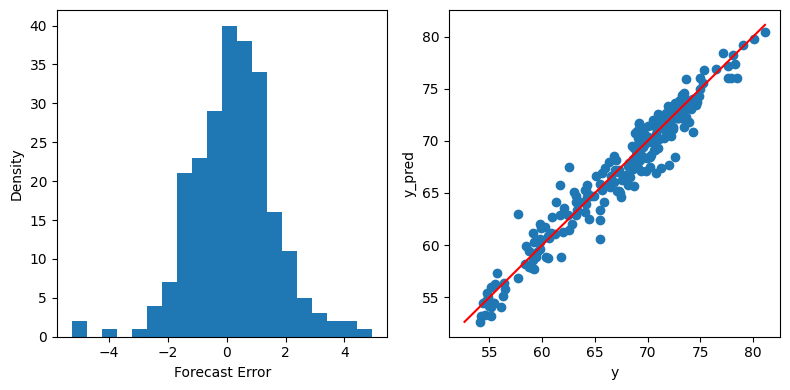

In [26]:
plot_model_performance(results)

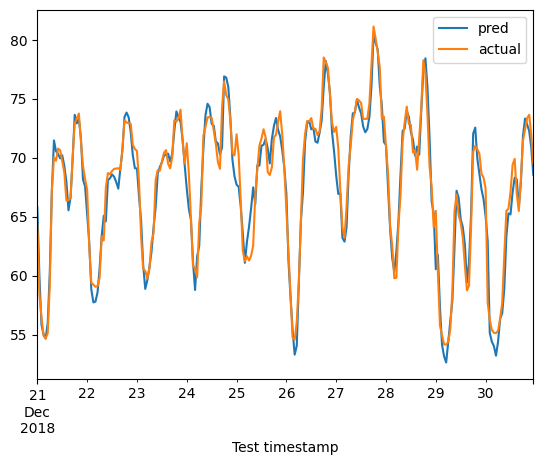

In [27]:
# Plot test predictions
results[['time','pred', 'actual']].set_index('time').plot()
plt.xlabel('Test timestamp')
plt.show()

In [28]:
def give_me_metrics(df):
    mae_test = mean_absolute_error(df.actual, df.pred)
    mse_test = mean_squared_error(df.actual, df.pred)
    rmse_test = mean_squared_error(df.actual, df.pred, squared=False)
    mape_test = mean_absolute_percentage_error(df.actual, df.pred)
    r2_test = r2_score(df.actual, df.pred)

    metric_df = pd.DataFrame({'MAE': [mae_test], 'MSE' : [mse_test], 'RMSE' : [rmse_test], 'MAPE': [mape_test], 'R2':[r2_test]})
    return metric_df

In [29]:
metrics = give_me_metrics(results)
metrics["model"] = "XGBoost"
metrics.set_index("model")

,MAE,MSE,RMSE,MAPE,R2
model,,,,,
XGBoost,1.09479,2.093366,1.446847,0.016378,0.943677


# Recursive Forecasting

## Multi-step forecasting using recursive strategy

In [41]:
# Forecasting 24 hours ahead
forecast_point = X_test.index.max() + pd.offsets.Hour(1)
forecast_end = forecast_point + pd.offsets.Hour(23)

index = pd.date_range(
    start= forecast_point,
    end= forecast_end,
    freq='1H'
)

f_horizon = pd.DataFrame(columns=['value'], index= index)

start_point = forecast_point - pd.offsets.Hour(25)
input_data = X_test[(X_test.index >= start_point) & (X_test.index < forecast_point)]

input_data.loc[forecast_point] = np.NaN
input_data_df = prep_pipeline.transform(input_data)
rec_preds = model.predict(input_data_df)

f_horizon.loc[forecast_point] = rec_preds
input_data.loc[forecast_point] = rec_preds

In [42]:
input_data_df

,day_of_month,year,week,day_of_week,weekend,quarter,semester,hour_sin,hour_cos,month_sin,...,value_corrected_lag_18,value_corrected_lag_19,value_corrected_lag_20,value_corrected_lag_21,value_corrected_lag_22,value_corrected_lag_23,value_corrected_lag_24,value_corrected_lag_25,value_corrected_window_24_mean,value_corrected_window_24_std
time,,,,,,,,,,,,,,,,,,,,,
2018-12-31 00:00:00+01:00,30,2018,52,6,1,4,2,-2.449294e-16,1.0,-2.449294e-16,...,55.34,55.13,55.15,55.4,56.27,57.69,67.38,68.31,64.524583,6.656863


In [43]:
for i in range(23):
    
    # Re-slice the input data
    start_point = start_point + pd.offsets.Hour(1)
    forecast_point = forecast_point + pd.offsets.Hour(1)

    input_data = input_data[(input_data.index >= start_point)]
    input_data.loc[forecast_point] = np.nan

    # Obtain the prediction
    pred = model.predict(prep_pipeline.transform(input_data))

    # Add prediction to horizon.
    f_horizon.loc[forecast_point] = pred
    input_data.loc[forecast_point] = pred

f_horizon.index.name = "time"

In [44]:
forecast_results = f_horizon.merge(out_of_sample_df, right_on="time", left_index=True) \
                            .rename(columns={"value": "pred", "value_corrected": "actual"})

<Axes: xlabel='time'>

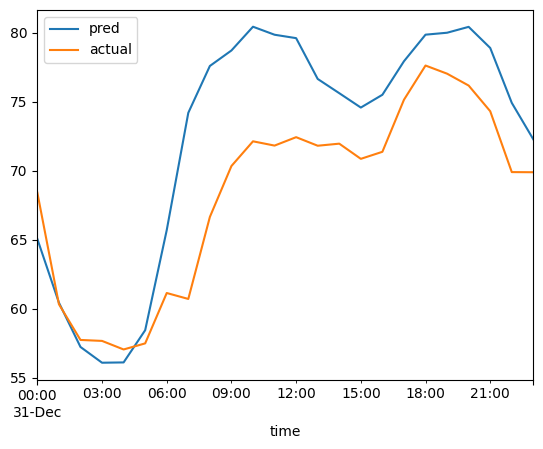

In [45]:
forecast_results.set_index("time").plot()

In [46]:
# Metrics
give_me_metrics(forecast_results)

,MAE,MSE,RMSE,MAPE,R2
0,4.536487,31.34274,5.598459,0.065936,0.280863
